In [1]:
import math
import random
import sys
from scipy import special
from tqdm import trange
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
class GlobalNetwork:
    def __init__(self, nodeNum, k):
        self.nodeNum = nodeNum #the total number of nodes in this network
        self.adjacencyMatrix = np.eye(self.nodeNum, dtype = int) #initialize the adjacency matrix of the global network
        self.k = k #the number of hops used in learning
        self.adjacencyMatrixPower = [np.eye(self.nodeNum, dtype = int)] #cache the powers of the adjacency matrix
        self.neighborDict = {} #use a hashmap to store the ((node, dist), neighbors) pairs which we have computed
        self.addingEdgesFinished = False #have we finished adding edges?
    
    #add an undirected edge between node i and j
    def addEdge(self, i, j):
        self.adjacencyMatrix[i, j] = 1
        self.adjacencyMatrix[j, i] = 1
    
    #finish adding edges, so we can construct the k-hop neighborhood after adding edges
    def finishAddingEdges(self):
        temp = np.eye(self.nodeNum, dtype = int)
        #the d-hop adjacency matrix is stored in self.adjacencyMatrixPower[d]
        for _ in range(self.k):
            temp = np.matmul(temp, self.adjacencyMatrix)
            self.adjacencyMatrixPower.append(temp)
        self.addingEdgesFinished = True
        print(self.adjacencyMatrixPower)
    
    #query the d-hop neighborhood of node i, return a list of node indices.
    def findNeighbors(self, i, d):
        if not self.addingEdgesFinished:
            print("Please finish adding edges before call findNeighbors!")
            return -1
        if (i, d) in self.neighborDict: #if we have computed the answer before, return it
            return self.neighborDict[(i, d)]
        neighbors = []
        for j in range(self.nodeNum):
            if self.adjacencyMatrixPower[d][i, j] > 0: #this element > 0 implies that dist(i, j) <= d
                neighbors.append(j)
        self.neighborDict[(i, d)] = neighbors #cache the answer so we can reuse later
        return neighbors

class AccessNetwork(GlobalNetwork):
    def __init__(self, nodeNum, k, accessNum):
        super(AccessNetwork, self).__init__(nodeNum, k)
        self.accessNum = accessNum
        self.accessMatrix = np.zeros((nodeNum, accessNum), dtype = int)
    
    #add an access point a for node i
    def addAccess(self, i, a):
        self.accessMatrix[i, a] = 1
        
    #finish adding access points. we can construct the neighbor graph
    def finishAddingAccess(self):
        #use accessMatrix to construct the adjacency matrix of (user) nodes
        self.adjacencyMatrix = np.matmul(self.accessMatrix, np.transpose(self.accessMatrix))
        
        #calculate the number of users sharing each access point
        self.numNodePerAccess = np.sum(self.accessMatrix,axis = 0)
        
        super(AccessNetwork, self).finishAddingEdges()
    
    #find the access points for node i
    def findAccess(self, i):
        accessPoints = []
        for j in range(self.accessNum):
            if self.accessMatrix[i, j] > 0:
                accessPoints.append(j)
        return accessPoints
    def setTransmitProb(self,transmitProb):
        self.transmitProb = transmitProb
        

class Node:
    def __init__(self, index):
        self.index = index
        self.state = [] #The list of local state at different time steps
        self.action = [] #The list of local actions at different time steps
        self.reward = [] #The list of local actions at different time steps
        self.currentTimeStep = 0 #Record the current time step.
        self.paramsDict = {} #use a hash map to query the parameters given a state (or neighbors' states)
        self.QDict = {} #use a hash map to query to the Q value given a (state, action) pair
        self.kHop = [] #The list to record the (state, action) pairs of k-hop neighbors
    #get the local Q at timeStep
    def getQ(self, kHopStateAction):
        #if the Q value of kHopStateAction hasn't been queried before, return 0.0 (initial value)
        return self.QDict.get(kHopStateAction, 0.0)
    
    #initialize the local state
    def initializeState(self):
        pass
    #update the local state, it may depends on the states of other nodes at the last time step.
    #Remember to increase self.currentTimeStep by 1
    def updateState(self):
        pass
    #update the local action
    def updateAction(self):
        pass
    #update the local reward
    def updateReward(self):
        pass
    #update the local Q value
    def updateQ(self):
        pass
    #update the local parameter
    def updateParams(self):
        pass
    #clear the record. Called when a new inner loop starts. 
    def restart(self, clearPolicy = True):
        self.state.clear()
        self.action.clear()
        self.reward.clear()
        if clearPolicy == True:
            self.paramsDict.clear()
        
        self.kHop = []
        self.currentTimeStep = 0

In [3]:
def constructLinearNetwork(nodeNum, k, nodePerBlock , transmitProb = 'allone'):
    #compute the number of access points
    accessNum = (nodeNum - 1)//nodePerBlock
        
    if accessNum <= 0:
        print("nodeNum is not large enough!")
        return null
    accessNetwork = AccessNetwork(nodeNum = nodeNum, k = k, accessNum = accessNum)
    for i in range(nodeNum):
        j = i//nodePerBlock
        if j >= 1:
            accessNetwork.addAccess(i, j - 1)
        if j < accessNum:
            accessNetwork.addAccess(i, j)
    accessNetwork.finishAddingAccess()
    
    
    # setting transmitProb 
    if transmitProb == 'allone':
        transmitProb = np.ones(accessNum)
    elif transmitProb == 'random':
        transmitProb = np.random.rand(accessNum)
    
    accessNetwork.setTransmitProb(transmitProb)
    return accessNetwork

def constructGridNetwork(nodeNum, width, height, k, nodePerGrid, transmitProb = 'allone'):
    if nodeNum != width * height * nodePerGrid:
        print("nodeNum does not satisfy the requirement of grid network!", nodeNum, width, height, nodePerGrid)
        return null
    accessNum = (width - 1) * (height - 1)
    accessNetwork = AccessNetwork(nodeNum = nodeNum, k = k, accessNum = accessNum)
    for j in range(accessNum):
        upperLeft = j//(width - 1) * width + j%(width - 1)
        upperRight = upperLeft + 1
        lowerLeft = upperLeft + width
        lowerRight = lowerLeft + 1
        for a in [upperLeft, upperRight, lowerLeft, lowerRight]:
            for b in range(nodePerGrid):
                accessNetwork.addAccess(nodePerGrid * a + b, j)
    accessNetwork.finishAddingAccess()
    
    # setting transmitProb 
    if transmitProb == 'allone':
        transmitProb = np.ones(accessNum)
    elif transmitProb == 'random':
        transmitProb = np.random.rand(accessNum)
    
    accessNetwork.setTransmitProb(transmitProb)

    return accessNetwork

In [4]:
class accessNodeAve(Node):
    def __init__(self, index, ddl, arrivalProb, accessNetwork):
        super(accessNodeAve, self).__init__(index)
        self.ddl = ddl #the initial deadline of each packet
        self.arrivalProb = arrivalProb #the arrival probability at each timestep
        self.gamma = 1.0 #the discount factor
        #we use packetQueue to represent the current local state, which is (e_1, e_2, ..., e_d)
        self.packetQueue = np.zeros(self.ddl, dtype = int) #use 1 to represent a packet with this remaining time, otherwise 0
        self.accessPoints = accessNetwork.findAccess(i=index) #find and cache the access points this node can access
        self.accessNum = len(self.accessPoints) #the number of access points
        self.actionNum = self.accessNum  + 1 #the number of possible actions
        self.stateNum = 2** self.ddl # number of possible states
        
        self.mu = 0.0 # estimate for average reward
        self.dummyState = tuple(np.zeros(self.ddl, dtype = int))
        self.dummyAction = -1
        #print('self.dummyStateAction' , self.dummyStateAction)
        #construct a list of possible actions
        self.actionList = [-1] #(-1, -1) is an empty action that does nothing
        for a in self.accessPoints:
            self.actionList.append( a)
    #remove the first element in packetQueue, and add packetState to the end
    def rotateAdd(self, packetState):
        #print('self.packetQueue[1:] =',self.packetQueue[1:],'self.ddl = ',self.ddl, 'packetState = ',packetState )
        self.packetQueue = np.insert(self.packetQueue[1:], self.ddl - 1, packetState)
        #print('new = ',self.packetQueue)
        
    #initialize the local state (called at the beginning of the training process)
    def initializeState(self):
        newPacketState = np.random.binomial(1, self.arrivalProb) #Is there a packer arriving at time step 0?
        self.rotateAdd(newPacketState) #get the packet queue at time step 0
        self.state.append(tuple(self.packetQueue)) #append this state to state record
    
    #At each time step t, call updateState, updateAction, updateReward, updateQ in this order
    def updateState(self):
        self.currentTimeStep += 1
        lastAction = self.action[-1]
        
        # find the earliest slot
        nonEmptySlots = np.nonzero(self.packetQueue == 1)
        
        if len(nonEmptySlots) >0: # queue not empty
            #if the reward at the last time step is positive, we have successfully send out a packet
            if self.reward[-1] > 1 - 1e-3:
                self.packetQueue[nonEmptySlots[0]] = 0 # earliest packet is sent
        
        #sample whether next packet comes
        newPacketState = np.random.binomial(1, self.arrivalProb) #Is there a packer arriving at time step 0?
        self.rotateAdd(newPacketState) #get the packet queue at time step 0
        self.state.append(tuple(self.packetQueue)) #append this state to state record
        if len(self.state)>2:
            self.state.pop(0)# only keep current
            
        
    def updateAction(self):
        # get the current state
        currentState = tuple(self.packetQueue)
        # fetch the params based on the current state. If haven't updated before, return all zeros
        params = self.paramsDict.get(currentState, np.zeros(self.actionNum))
        # compute the probability vector
        probVec = special.softmax(params)
        # randomly select an action based on probVec
        currentAction = self.actionList[np.random.choice(a = self.actionNum, p = probVec)]
        
        self.action.append(currentAction)
        if(len(self.action)>2):
            self.action.pop(0) # through away the first one. Only keep current and last action
    
    #oneHopNeighbors is a list of accessNodes
    def updateReward(self, oneHopNeighbors, accessNetwork):
        #decide if a packet is successfully sending out
        currentAction = self.action[-1]
        if currentAction == -1: # the do nothing action
            self.reward.append(0.0)
            if(len(self.reward)>2):
                self.reward.pop(0)
            return
        currentState = np.array(self.state[-1])
        
        #check if the node try to send out an empty slot
        if np.all(currentState == 0): # if the current queue is empty
            # zero reward
            self.reward.append(0.0)
            if(len(self.reward)>2):
                self.reward.pop(0)
            return

        
        for neighbor in oneHopNeighbors:
            if neighbor.index == self.index:
                continue
            neighborAction = neighbor.action[-1]
            
            if neighborAction != currentAction: 
                continue
            else:
                neighborState = np.array(neighbor.state[-1])
                #print('neighborState', neighborState)
                if np.any(neighborState == 1): # neighbor queue non empty, conflict!
                    #print('conflict!')
                    self.reward.append(0.0)
                    if(len(self.reward)>2):
                        self.reward.pop(0)
                    return
        
        # no conflict, send
        transmitSuccess = np.random.binomial(1, accessNetwork.transmitProb[currentAction])
        if transmitSuccess == 1:
            self.reward.append(1.0)
            if(len(self.reward)>2):
                self.reward.pop(0)
            return
        else:
            self.reward.append(0.0)
            if(len(self.reward)>2):
                self.reward.pop(0)
            return

    def isDummyStateAction(self,state,action):
        if state == self.dummyState and action == self.dummyAction:
            #print(self.dummyState,'==',state,', ',self.dummyAction,'==',action)
            return True
        else:
            #print(self.dummyState,'!=',state,', ',self.dummyAction,'!=',action)
            return False
                                
    
    #kHopNeighbors is a list of accessNodes, alpha is learning rate
    def updateQ(self, kHopNeighbors, alpha):
        lastStateAction = []
        currentStateAction = []
        #construct a list of the state-action pairs of k-hop neighbors
        dummyFlag = []
        for neighbor in kHopNeighbors:
            neighborLastState = neighbor.state[-2]
            neighborCurrentState = neighbor.state[-1]
            neighborLastAction = neighbor.action[-2]
            neighborCurrentAction = neighbor.action[-1]
            lastStateAction.append((neighborLastState, neighborLastAction))
            currentStateAction.append((neighborCurrentState, neighborCurrentAction))
            dummyFlag.append(neighbor.isDummyStateAction(neighborLastState,neighborLastAction))
        lastStateAction = tuple(lastStateAction)
        currentStateAction = tuple(currentStateAction)
        #fetch the Q value based on neighbors' states and actions
        lastQTerm1 = self.QDict.get(lastStateAction, 0.0)
        lastQTerm2 = self.QDict.get(currentStateAction, 0.0)
        #compute the temporal difference
        
        self.mu = (1-alpha) * self.mu + alpha* self.reward[-1] # compute new mu
        
        
        temporalDiff = self.reward[-2] - self.mu+  lastQTerm2 - lastQTerm1
        #print('lastStateAction',lastStateAction)
        #perform the Q value update when last state action is not dummy
        if not all(dummyFlag):
            self.QDict[lastStateAction] = lastQTerm1 + alpha * temporalDiff
            #print(self.QDict[lastStateAction])
        # if this time step 1, we should also put lastStateAction into history record
        
        #if len(self.kHop) == 0:
            #self.kHop.append(lastStateAction)
        #put currentStateAction into history record
        self.kHop = currentStateAction
    
    #eta is the learning rate
    def updateParams(self, kHopNeighbors, eta):
        #for t = 0, 1, ..., T, compute the term in g_{i, t}(m) before \nabla
        mutiplier1 = 0.0
        t = self.currentTimeStep
        #print(' t = ', t,', khop = ', self.kHop)
        for neighbor in kHopNeighbors:
            neighborKHop = neighbor.kHop
            neighborQ = neighbor.getQ(neighborKHop)
            mutiplier1 += neighborQ
        
        mutiplier1 /= nodeNum
        #finish constructing mutiplier1
        #compute the gradient with respect to the parameters associated with s_i(t)
        currentState = self.state[-1]
        currentAction = self.action[-1]
        
        defaultPolicy = np.zeros(self.actionNum)
        defaultPolicy[0]=2
        
        # for test only!!!
#         if self.index == 0:
#             defaultPolicy[1]=-1
        # End of Test!!!
        
        
        params = self.paramsDict.get(currentState, defaultPolicy)
        probVec = special.softmax(params)
        grad = -probVec
        actionIndex = self.actionList.index(currentAction) #get the index of currentAction
        grad[actionIndex] += 1.0
        self.paramsDict[currentState] = params + eta * mutiplier1 * grad
        #print('t=',t ,'  id = ', self.index, '  current state=', len(currentState),' grad = ',grad, 'mutiplier1 =', mutiplier1, 'params=', params)

    def setBenchmarkPolicy(self,accessNetwork): # set a naive benchmarkPolicy
        proportionAction = []
        for actionCounter in range(self.actionNum):
            if self.actionList[actionCounter] == -1:
                proportionAction.append(np.log(100*.11/4.0))
            else:
                numNodePerAccess = float(accessNetwork.numNodePerAccess[self.actionList[actionCounter]])
                transmitProb = float(accessNetwork.transmitProb[self.actionList[actionCounter]])
                print('numNodePerAccess = ',numNodePerAccess,' transmitProb = ',transmitProb)
                proportionAction.append( np.log(100*transmitProb/numNodePerAccess))
            
        
        for stateInt in range(self.stateNum): # enumerate state
            currentState = self.int2state(stateInt) # turn state integer into binary list
            actionParams = np.ones(self.actionNum,dtype = float) * (-10) # default to be all negative
            
            
            if np.all( currentState == 0): # no packet in queue
                actionParams[0] = 10.0 # do nothing
            else:
                actionParams = np.array(proportionAction) # proportional action
            # update paramsDict
            self.paramsDict[tuple(currentState)] = actionParams
                
            
        
    def int2state(self,stateInt):
        currentState = np.zeros(self.ddl,dtype = int)
        stateIntIterate = stateInt
        for i in range(ddl):
            currentState[i] = stateIntIterate% self.ddl
            stateIntIterate = stateIntIterate//self.ddl
        return currentState

In [5]:
class MultiAccessNetworkRL:
    def __init__(self,ddl = 2, graphType = 'line', nodeNum = 10, maxK = 3 ,arrivalProb = None, transmitProb = 'random', gridW = 1, gridH = 1):
        self.ddl = ddl
        self.nodeNum = nodeNum
        self.maxK = maxK
        if(arrivalProb == None):
            self.arrivalProb = np.random.rand(nodeNum)
        else:
            self.arrivalProb = arrivalProb
            
        if graphType == 'line':
            self.accessNetwork = constructLinearNetwork(nodeNum = nodeNum, nodePerBlock = 1, k = maxK,transmitProb= transmitProb)
        else:
            self.accessNetwork =  constructGridNetwork(nodeNum = nodeNum, width = gridW, height = gridH, k = maxK, nodePerGrid = 1,transmitProb= transmitProb)
            
        self.nodeList = []
        for i in range(nodeNum):
            self.nodeList.append(accessNodeAve(index = i, ddl = ddl, arrivalProb = self.arrivalProb[i], accessNetwork = self.accessNetwork) )
       
    def train(self, k = 1, M = 10000, evalInterval = 500, restartIntervalQ = 50, restartIntervalPolicy = 50, clearPolicy = True):
        for i in range(self.nodeNum):
            self.nodeList[i].restart(clearPolicy)
            self.nodeList[i].initializeState()
            self.nodeList[i].updateAction()
        
        for i in range(self.nodeNum):
            neighborList = []
            for j in self.accessNetwork.findNeighbors(i, 1):
                neighborList.append(self.nodeList[j])
            self.nodeList[i].updateReward(neighborList,self.accessNetwork)
            
        
        policyRewardList = []
        policyRewardSmooth = []
        policyRewardMuSmooth = []
        policyRewardMu = []
        for m in trange(M):
            tmpReward = 0.0
            tmpRewardMu = 0.0
            for i in range(self.nodeNum): #update state-action
                self.nodeList[i].updateState()
                self.nodeList[i].updateAction()
            
            for i in range(self.nodeNum):
                neighborList = []
                for j in self.accessNetwork.findNeighbors(i, 1):
                    neighborList.append(self.nodeList[j])
                self.nodeList[i].updateReward(neighborList,self.accessNetwork)
                
                tmpReward += self.nodeList[i].reward[-1] # add latest reward
                tmpRewardMu += self.nodeList[i].mu
                
            policyRewardList.append(tmpReward/self.nodeNum)
            policyRewardMu.append(tmpRewardMu/self.nodeNum)
            
            if m%evalInterval == evalInterval - 1:
                policyRewardSmooth.append(np.mean(policyRewardList[-evalInterval+2:-1]) )
                policyRewardMuSmooth.append(np.mean(policyRewardMu[-evalInterval+2:-1]) )
            for i in range(self.nodeNum):
                neighborList = []
                for j in self.accessNetwork.findNeighbors(i, k):
                    neighborList.append(self.nodeList[j])
                self.nodeList[i].updateQ(neighborList, 1/pow((m%restartIntervalQ)+1,.4)  )

            #perform the grad update
            for i in range(self.nodeNum):
                neighborList = []
                for j in self.accessNetwork.findNeighbors(i, k):
                    neighborList.append(self.nodeList[j])
                self.nodeList[i].updateParams(neighborList,  1.0* 1/pow((m%restartIntervalPolicy)+1,.6))
                
            #print(m%restartIntervalPolicy)
            if m > M*0.9: # for the last 10% of running, no restarting
                restartIntervalQ = max(int(M*0.5),restartIntervalQ)
                restartIntervalPolicy = max(int(M*0.5),restartIntervalPolicy)
            #perform a policy evaluation
        
        return policyRewardSmooth, policyRewardMuSmooth
    
    def evaluateBenchmarkPolicy(self, M=10000):

        
        for i in range(self.nodeNum):
            self.nodeList[i].restart()
            self.nodeList[i].setBenchmarkPolicy(self.accessNetwork)
            self.nodeList[i].initializeState()
            self.nodeList[i].updateAction()
        
        for i in range(self.nodeNum):
            neighborList = []
            for j in self.accessNetwork.findNeighbors(i, 1):
                neighborList.append(self.nodeList[j])
            self.nodeList[i].updateReward(neighborList,self.accessNetwork)

        policyRewardList = []

        for m in trange(M):
            tmpReward = 0.0
            for i in range(self.nodeNum): #update state-action
                self.nodeList[i].updateState()
                self.nodeList[i].updateAction()

            for i in range(self.nodeNum):
                neighborList = []
                for j in self.accessNetwork.findNeighbors(i, 1):
                    neighborList.append(self.nodeList[j])
                self.nodeList[i].updateReward(neighborList,self.accessNetwork)
                tmpReward += self.nodeList[i].reward[-1] # add latest reward
            policyRewardList.append(tmpReward/self.nodeNum)

        return np.mean(policyRewardList)


In [6]:
ddl = 2

np.random.seed(0)

# linear network
# nodeNum = 5 #number of nodes in the network
# maxK = 2 #the size of neighborhood we use in localized learning
# arrivalProb = [.3,.9, .9] *2
# transmitProb = [ .9,.9]   + [.02, .9, .9 ]*1
# networkRLModel = MultiAccessNetworkRL(ddl = 2, graphType = 'line', \
#                                       nodeNum = nodeNum, maxK = maxK ,arrivalProb = arrivalProb,transmitProb = transmitProb)
# evalInterval = 500 #evaluate the policy every evalInterval rounds (outer loop)
# M = 10000
# restartIntervalQ = 500;
# restartIntervalPolicy = 500


gridW = 6
gridH = 6
nodeNum = gridW*gridH #number of nodes in the network
minK = 0
maxK = 1 #the size of neighborhood we use in localized learning
arrivalProb = None
transmitProb = 'random'
networkRLModel = MultiAccessNetworkRL(ddl = 2, graphType = 'grid', \
                                      nodeNum = nodeNum, maxK = maxK ,arrivalProb = arrivalProb,transmitProb = transmitProb,gridW = gridW, gridH = gridH)
evalInterval = 500 #evaluate the policy every evalInterval rounds (outer loop)
M = 300000
restartIntervalQ = 10
restartIntervalPolicy = 10

np.random.seed()






[array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]]), array([[1, 1, 0, ..., 0, 0, 0],
       [1, 2, 1, ..., 0, 0, 0],
       [0, 1, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 1, 0],
       [0, 0, 0, ..., 1, 2, 1],
       [0, 0, 0, ..., 0, 1, 1]])]


In [7]:
benchMarkReward = networkRLModel.evaluateBenchmarkPolicy()

print('benchmark reward is: ', benchMarkReward)

  0%|          | 12/10000 [00:00<01:24, 118.74it/s]

numNodePerAccess =  4.0  transmitProb =  0.3637107709426226
numNodePerAccess =  4.0  transmitProb =  0.3637107709426226
numNodePerAccess =  4.0  transmitProb =  0.5701967704178796
numNodePerAccess =  4.0  transmitProb =  0.5701967704178796
numNodePerAccess =  4.0  transmitProb =  0.43860151346232035
numNodePerAccess =  4.0  transmitProb =  0.43860151346232035
numNodePerAccess =  4.0  transmitProb =  0.9883738380592262
numNodePerAccess =  4.0  transmitProb =  0.9883738380592262
numNodePerAccess =  4.0  transmitProb =  0.10204481074802807
numNodePerAccess =  4.0  transmitProb =  0.10204481074802807
numNodePerAccess =  4.0  transmitProb =  0.2088767560948347
numNodePerAccess =  4.0  transmitProb =  0.2088767560948347
numNodePerAccess =  4.0  transmitProb =  0.3637107709426226
numNodePerAccess =  4.0  transmitProb =  0.16130951788499626
numNodePerAccess =  4.0  transmitProb =  0.3637107709426226
numNodePerAccess =  4.0  transmitProb =  0.5701967704178796
numNodePerAccess =  4.0  transmitPr

100%|██████████| 10000/10000 [01:10<00:00, 141.26it/s]

benchmark reward is:  0.11381224489795919


In [8]:


policyRewardSmoothList = []
policyRewardMuList = []
finalRewardList = []
aveRewardMu = []
for k in range(minK,maxK+1):
    policyRewardSmooth, policyRewardMu = networkRLModel.train(k = k, M = M, evalInterval = evalInterval,restartIntervalQ = restartIntervalQ\
                                 , restartIntervalPolicy = restartIntervalPolicy, clearPolicy = True)
    tmp = 0.0
    for i in range(nodeNum):
        print('ave reward of node ',str(i), '= ',str(networkRLModel.nodeList[i].mu))
        print('policy of of node ', str(i), '= ',networkRLModel.nodeList[i].paramsDict)
        tmp+=networkRLModel.nodeList[i].mu
    aveRewardMu.append(tmp/nodeNum)
    policyRewardSmoothList.append(policyRewardSmooth)
    policyRewardMuList.append(policyRewardMu)
    finalRewardList.append(policyRewardSmooth[-1])


  0%|          | 8/400000 [00:00<1:36:33, 69.04it/s]

ave reward of node  0 =  0.07760570984107384
policy of of node  0 =  {(1, 1): array([-1.57095648,  3.57095648]), (1, 0): array([-1.40498682,  3.40498682]), (0, 1): array([-1.69720924,  3.69720924]), (0, 0): array([ 2.36954971, -0.36954971])}
ave reward of node  1 =  0.4159914928932764
policy of of node  1 =  {(0, 1): array([-1.88317993, -1.7884103 ,  5.67159023]), (1, 0): array([-1.24099652, -1.30358513,  4.54458165]), (0, 0): array([ 4.37801928, -1.14958322, -1.22843606]), (1, 1): array([-1.61684683, -1.59301838,  5.20986521])}
ave reward of node  2 =  0.07666464864019949
policy of of node  2 =  {(0, 1): array([-1.71926075, -0.7555928 ,  4.47485355]), (1, 0): array([-1.3010464 , -0.33989547,  3.64094187]), (1, 1): array([-1.41255446, -0.89223226,  4.30478672]), (0, 0): array([ 2.53285028, -0.44406825, -0.08878202])}
ave reward of node  3 =  0.05259390960660006
policy of of node  3 =  {(1, 1): array([-1.53107034,  3.95754832, -0.42647798]), (0, 1): array([-1.66940373,  4.22022293, -0.5

100%|██████████| 400000/400000 [4:12:04<00:00, 26.45it/s]    


ave reward of node  0 =  0.27115395459841984
policy of of node  0 =  {(1, 1): array([-1.93150723,  3.93150723]), (1, 0): array([-1.89788918,  3.89788918]), (0, 1): array([-2.26740373,  4.26740373]), (0, 0): array([ 2.76354259, -0.76354259])}
ave reward of node  1 =  0.4470853823392338
policy of of node  1 =  {(1, 1): array([-1.19268846, -2.01442319,  5.20711165]), (1, 0): array([-0.62273167, -1.61976899,  4.24250066]), (0, 1): array([-1.56065626, -1.9904096 ,  5.55106585]), (0, 0): array([-0.29406941,  0.82084516,  1.47322425])}
ave reward of node  2 =  0.3731811795844744
policy of of node  2 =  {(1, 1): array([-1.16469134, -1.66382932,  4.82852066]), (1, 0): array([-0.73514679, -1.66254531,  4.3976921 ]), (0, 1): array([-1.27966311, -1.89745165,  5.17711475]), (0, 0): array([0.4223223 , 0.79406595, 0.78361175])}
ave reward of node  3 =  0.1699975449038472
policy of of node  3 =  {(0, 0): array([1.36063827, 0.37353528, 0.26582645]), (0, 1): array([ 1.06023034, -2.18715124,  3.1269209 ]

average reward calculated by mu =  [0.16083564496538508, 0.1452679076725471]
average reward calculated by averaging =  [0.16297786720321933, 0.1454440931302098]


Text(0.5, 0, '$t$')

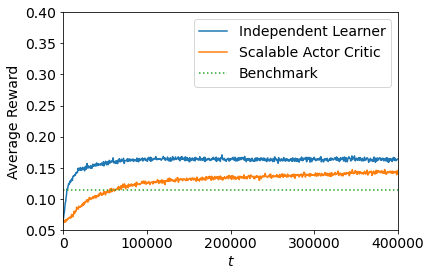

In [11]:
plt.rc('font', size=14)  


print('average reward calculated by mu = ', aveRewardMu)

print('average reward calculated by averaging = ', finalRewardList)
legendStr = []
for kInd in range(minK,maxK+1):
    plt.plot(np.linspace(1,M,len(policyRewardSmooth)), policyRewardSmoothList[kInd-minK])
    if kInd == 0:
        legendStr.append('Independent Learner')
    else:
        legendStr.append('Scalable Actor Critic')

plt.plot(np.linspace(1,M,len(policyRewardSmooth)), benchMarkReward*np.ones(len(policyRewardSmooth),dtype = float), linestyle = ':')
legendStr.append('Benchmark')
plt.xlim(0,M)
plt.ylim(0.05,.4)
plt.legend(legendStr)
plt.ylabel('Average Reward')
plt.xlabel('$t$')
#plt.savefig('neuripsfinal_grid36_k01.png',bbox_inches='tight')

# plt.show()
# for kInd in range(maxK+1):
#     plt.plot(np.linspace(1,M,len(policyRewardMu)), policyRewardMuList[kInd])
#     legendStr.append('$\kappa = '+str(kInd)+'$')
# plt.legend(legendStr)
#plt.xlim((M/2,M))